<a href="https://colab.research.google.com/github/jordanbell2357/Keras/blob/main/timeseries_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries classification from scratch

**Author:** [hfawaz](https://github.com/hfawaz/)<br>
**Date created:** 2020/07/21<br>
**Last modified:** 2023/08/25<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.

## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

http://www.j-wichard.de/publications/FordPaper.pdf

> **Abstract**— *In this work we apply mixed ensemble models in
order to build a classifier for the Ford Classification Challenge.
We build feature vectors from the data sequences in terms of
first order statistics, spectral density and autocorrelation. Our
model selection scheme is a mixture of cross-validation and
bagging. The outcome is an ensemble model, that consits of
several different models trained on random subsamples of the
entire data set.*

> The Ford Classification Challenge [1] consists of two data
sets that include data samples from an automotive subsystem.
The data was collected in batches of N = 500 samples per
diagnostic session, splitted in a training, a validation and a
test set. The size of training, validation and test set is listed
in Table I. The training set provided also the classification
labels, wherein +1 indicates that a specific symptom exists
and -1 indicates that the symptom does not exist. Later during
the competition, the validation labels were also published on
the competition website [1].

> [1] M. Abou-Nasr and L. Feldkamp, “Ford Classification Challenge,”
http://home.comcast.net/˜nn-classification.
>
> [2] “IEEE World Congress on Computational Intelligence (WCCI),”
http://www.wcci2008.org/.

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [3]:
len(x_train[0])

500

In [4]:
y_train[0]

-1

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

In [5]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))
classes

array([-1,  1])

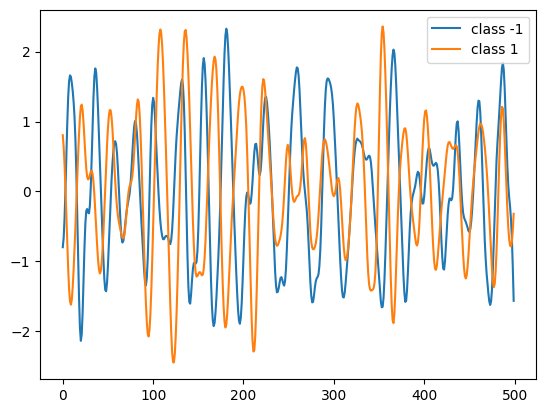

In [6]:
plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [7]:
x_train.shape

(3601, 500)

In [8]:
x_test.shape

(1320, 500)

In [9]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [10]:
x_train.shape

(3601, 500, 1)

In [11]:
x_test.shape

(1320, 500, 1)

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [12]:
num_classes = len(np.unique(y_train))
num_classes

2

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [13]:
idx = np.random.permutation(len(x_train))
print(type(idx))
print(idx[0], idx[1])

<class 'numpy.ndarray'>
287 1979


In [14]:
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [15]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

https://arxiv.org/abs/1611.06455

https://ieeexplore.ieee.org/document/7966039

Z. Wang, W. Yan and T. Oates, "Time series classification from scratch with deep neural networks: A strong baseline," 2017 International Joint Conference on Neural Networks (IJCNN), Anchorage, AK, USA, 2017, pp. 1578-1585, doi: 10.1109/IJCNN.2017.7966039.

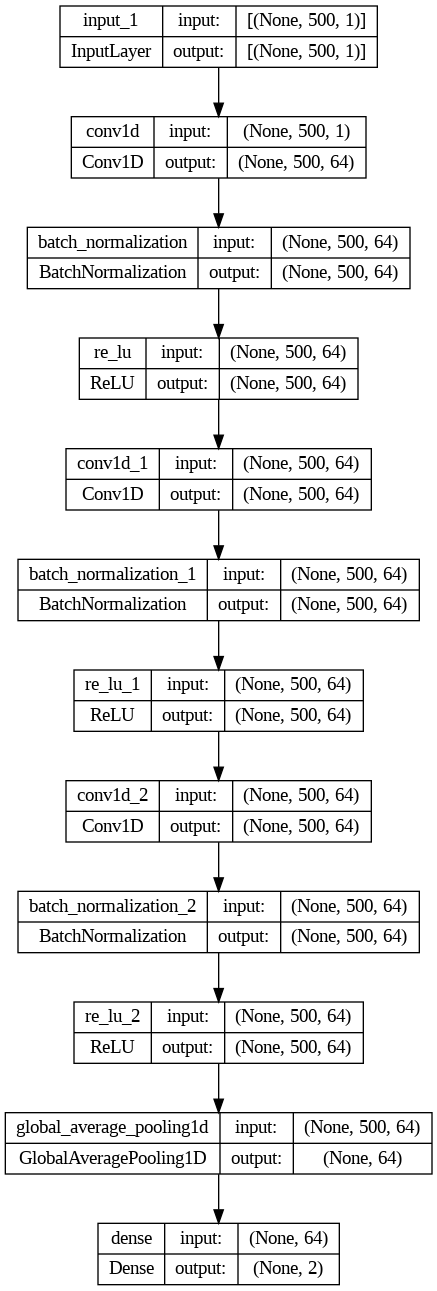

In [16]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [17]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 15s 12ms/step - loss: 0.5741 - sparse_categorical_accuracy: 0.6885 - val_loss: 0.7459 - val_sparse_categorical_accuracy: 0.5007 - lr: 0.0010
Epoch 2/500
20/90 [=====>........................] - ETA: 0s - loss: 0.4806 - sparse_categorical_accuracy: 0.7688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 1s 7ms/step - loss: 0.4606 - sparse_categorical_accuracy: 0.7705 - val_loss: 0.8364 - val_sparse_categorical_accuracy: 0.5007 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 1s 8ms/step - loss: 0.4211 - sparse_categorical_accuracy: 0.7892 - val_loss: 0.7295 - val_sparse_categorical_accuracy: 0.5007 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 1s 6ms/step - loss: 0.4206 - sparse_categorical_accuracy: 0.7906 - val_loss: 0.9039 - val_sparse_categorical_accuracy: 0.5007 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 1s 7ms/step - loss: 0.3997 - sparse_categorical_accuracy: 0.7997 - val_loss: 0.6161 - val_sparse_categorical_accuracy: 0.6588 - lr: 0.0010
Epoch 6/500
90/90 [==============================] - 1s 6ms/step - loss: 0.4126 - sparse_categorical_accuracy: 0.7851 - val_loss: 1.0547 - val_sparse_categorical_accuracy: 0.5229 - lr: 0.0010
Epoch 7/500
90/90 [==============================] -

## Evaluate model on test data

In [18]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 5ms/step - loss: 0.0942 - sparse_categorical_accuracy: 0.9667
Test accuracy 0.9666666388511658
Test loss 0.09416236728429794


## Plot the model's training and validation loss

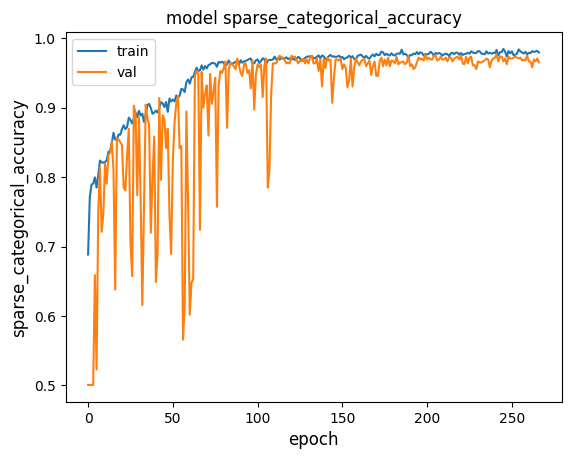

In [19]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.

Example available on HuggingFace:

| Trained Model | Demo |
|------|------|
| [![🤗 Model - Timeseries classification from scratch](https://img.shields.io/badge/🤗_Model-Timeseries_classification_from_scratch-black)](https://huggingface.co/keras-io/timeseries-classification-from-scratch) | [![🤗  Spaces - Timeseries classification from scratch](https://img.shields.io/badge/🤗_Spaces-Timeseries_classification_from_scratch-black)](https://huggingface.co/spaces/keras-io/timeseries-classification-from-scratch) |

https://huggingface.co/keras-io/timeseries-classification-from-scratch

https://huggingface.co/spaces/keras-io/timeseries-classification-from-scratch

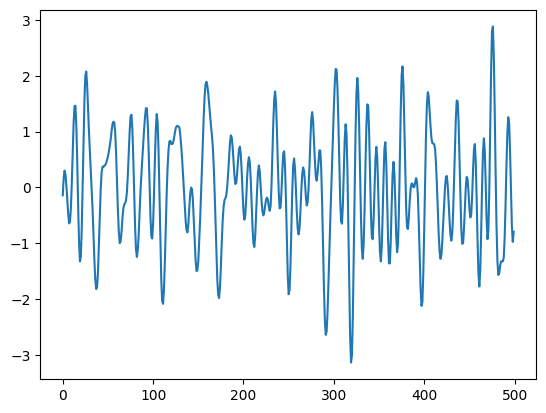

In [20]:
plt.plot(x_test[0])

In [24]:
len(model.predict(x_test[0]))

16/16 [==============================] - 0s 3ms/step


500

In [25]:
model.predict_on_batch(x_test[0])

array([[5.37696643e-09, 1.00000000e+00],
       [6.22968239e-25, 1.00000000e+00],
       [1.27060938e-33, 1.00000000e+00],
       [6.29409253e-29, 1.00000000e+00],
       [2.32340644e-12, 1.00000000e+00],
       [1.61700403e-16, 1.00000000e+00],
       [8.08879116e-33, 1.00000000e+00],
       [1.72746335e-37, 1.00000000e+00],
       [6.43826512e-37, 1.00000000e+00],
       [1.53716582e-28, 1.00000000e+00],
       [5.42975251e-17, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [1.30821616e-24, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.72809181e-13, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.000000